<center style='font-size:28px;'><u><b>Supervised Learning</b></u></center>

1. [Project Description](#start)
    * [Data Description](#dd)
2. [Imports](#imp)
3. [Preprocessing data](#pp)    
4. [Model Training - Disregarding Class Imbalance](#mtdci)
    * [Categorising `churn`'s columns](#cgcscs)
    * [Tree Approach](#trap)
        * [Label Encoding](#labenc)
        * [OHE](#ohe)
    * [Logistic Regression Approach](#lograp)
    * [Class Balance Analysis](#claba)
    * [Initial Training Summation](#intsum)
5. [Fixing Class Imbalance](#fxclimb)
    * [Tree Approach](#trapp)
    * [Logistic Regression Approach](#lograpp)
    * [Imbalance Fix Summation](#imbfsu)
5. [Final Testing](#fintest)
5. [Conclusion](#conc)

# Project description <a id="start"></a>

<ul>Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.</ul>
<ul>They want to know if a customer will leave the bank soon.</ul>
<ul>Using data on clients’ past behavior and termination of contracts with the bank, predictions will be held.</ul>

<div><b>In particular:</b></div>

- A model for predicting leaving customers will be built, aiming for a F1 score greater than 0.59
- Models will be trained, tuned and evaluated
- Class imbalance effect on model performance will be fixed and analysed
- AUC-ROC and F1 metrics will be calculated before and after balancing

## Description of the data <a id="dd"></a>

**Churn**
- Features
<ul>RowNumber — data string index</ul>
<ul>CustomerId — unique customer identifier</ul>
<ul>Surname — surname</ul>
<ul>CreditScore — credit score</ul>
<ul>Geography — country of residence</ul>
<ul>Gender — gender</ul>
<ul>Age — age</ul>
<ul>Tenure — period of maturation for a customer’s fixed deposit (years)</ul>
<ul>Balance — account balance</ul>
<ul>NumOfProducts — number of banking products used by the customer</ul>
<ul>HasCrCard — customer has a credit card</ul>
<ul>IsActiveMember — customer’s activeness</ul>
<ul>EstimatedSalary — estimated salary</ul>
- Target
<ul>Exited — сustomer has left</ul>

# Imports <a id="imp"></a>

In [1]:
#pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Pre-Processing <a id="pp"></a>

In [3]:
try:
    churn = pd.read_csv('Churn.csv')
except:
    churn = pd.read_csv('/datasets/Churn.csv')

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
churn.RowNumber.nunique()

10000

In [6]:
display(churn.Tenure.value_counts().sort_values())
churn.Tenure.median()

0.0     382
10.0    446
6.0     881
9.0     882
4.0     885
7.0     925
5.0     927
3.0     928
8.0     933
2.0     950
1.0     952
Name: Tenure, dtype: int64

5.0

In [7]:
print(f'{churn[churn.Tenure.isna()].CustomerId.nunique()}')
print(f'{churn.CustomerId.nunique()}')

909
10000


9% of customers have an unknown `Tenure`. Median value can be filled for them.

In [8]:
churn.Tenure = churn.Tenure.fillna(5)

In [9]:
churn = churn.astype({'Surname': 'string','Tenure': 'int64', 'Exited': bool}) # Tenure is all ints anyway
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  string 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  bool   
dtypes: bool(1), float64(2), int64(8), object(2), string(1)
memory usage: 1.0+ MB


In [10]:
churn.duplicated().sum()

0

In [11]:
churn = churn.drop(columns=['RowNumber','CustomerId','Surname']) # don't add any information

Data is now pre-processed "classical way" - The problem faced is categorical hence OHE/label encoding and scaling shall be applied as well, for logistic and tree approaches respectively. After models are established, class imbalanced well be tackled using up and down-sampling and threshold adjusting.

# Model Training - Disregarding Class Imbalance <a id="mtdci"></a>

## Categorising `churn`'s columns <a id="cgcscs"></a>

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = churn.select_dtypes(include=numerics)
churn_numeric = list(newdf.columns)
tmp = ['HasCrCard', 'IsActiveMember']
churn_numeric = [e for e in churn_numeric if e not in tmp]
print(churn_numeric)
churn_cat = ['Geography','Gender','HasCrCard','IsActiveMember']
print(churn_cat)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']


## Tree Approach <a id="trap"></a>

### Label Encoding <a id="labenc"></a>

In [13]:
encoder = OrdinalEncoder()

d = pd.DataFrame()
d[churn_cat] = pd.DataFrame(encoder.fit_transform(churn[churn_cat]), columns=churn[churn_cat].columns)
d[churn_numeric] = churn[churn_numeric]
d = d[churn.drop('Exited', axis=1).columns]

target = churn['Exited']
features = d

features_train, features_valid, target_train, target_valid = train_test_split\
(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split\
(features_valid, target_valid, test_size=0.5, random_state=12345)

scaler = StandardScaler()
scaler.fit(features_train[churn_numeric])
features_train[churn_numeric] = scaler.transform(features_train[churn_numeric])
features_valid[churn_numeric] = scaler.transform(features_valid[churn_numeric])
features_test[churn_numeric] = scaler.transform(features_test[churn_numeric])

ci, tmp = 0,0
for i in range(1,30):
    model = RandomForestClassifier(random_state=12345, n_estimators = i)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid,predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), i
print(f'Best n_estimators value - {ci}. F1 score - {tmp}')

ci, tmp = 0,0
for i in range(1,30):
    model = RandomForestClassifier(random_state=12345, n_estimators = 7, max_depth = i)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid,predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), i
print(f'Best max_depth value - {ci}. F1 score - {tmp}')

model = RandomForestClassifier(random_state=12345, n_estimators = 7, max_depth = 22)
model.fit(features_train,target_train)
predicted_test = model.predict(features_test)
print()
print('Test set F1 score -',f1_score(target_test,predicted_test))

Best n_estimators value - 7. F1 score - 0.5770862800565771
Best max_depth value - 22. F1 score - 0.5975103734439833

Test set F1 score - 0.5007278020378457


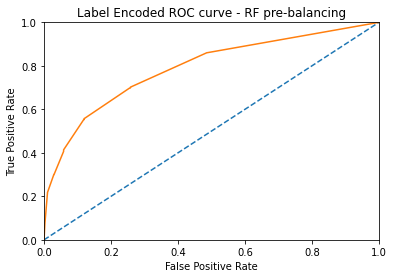

AUC-ROC score (validation set):  0.8082192609439931
AUC-ROC score:  0.7892578151351206


In [14]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Label Encoded ROC curve - RF pre-balancing')
plt.show()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
print('AUC-ROC score (validation set): ',auc_roc)

auc_roc = roc_auc_score(target_test,probabilities_one_test)
print('AUC-ROC score: ',auc_roc)

### OHE <a id="ohe"></a>

In [15]:
data_ohe = pd.get_dummies(churn, drop_first=True)

target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split\
(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split\
(features_valid, target_valid, test_size=0.5, random_state=12345)

scaler = StandardScaler()
scaler.fit(features_train[churn_numeric])
features_train[churn_numeric] = scaler.transform(features_train[churn_numeric])
features_valid[churn_numeric] = scaler.transform(features_valid[churn_numeric])
features_test[churn_numeric] = scaler.transform(features_test[churn_numeric])

ci, tmp = 0,0
for i in range(1,30):
    model = RandomForestClassifier(random_state=12345, n_estimators = i)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid,predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), i
print(f'Best n_estimators value - {ci}. F1 score - {tmp}')

ci, tmp = 0,0
for i in range(1,30):
    model = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = i)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid,predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), i
print(f'Best max_depth value - {ci}. F1 score - {tmp}')

model = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = 25)
model.fit(features_train,target_train)
predicted_test = model.predict(features_test)
print()
print('Test set F1 score -',f1_score(target_test,predicted_test))

Best n_estimators value - 23. F1 score - 0.5884057971014492
Best max_depth value - 25. F1 score - 0.5884057971014492

Test set F1 score - 0.5289747399702823


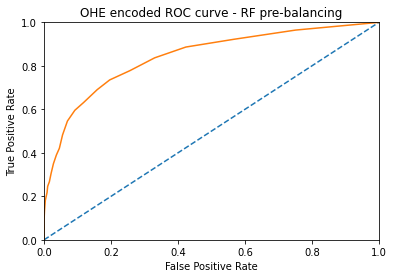

AUC-ROC score (validation set):  0.8332647790030184
AUC-ROC score:  0.841442665023663


In [16]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OHE encoded ROC curve - RF pre-balancing')
plt.show()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
print('AUC-ROC score (validation set): ',auc_roc)

auc_roc = roc_auc_score(target_test,probabilities_one_test)
print('AUC-ROC score: ',auc_roc)

For validation set, Label Encoding had the better F1 score, while for the test set - OHE had the better F1 score. As for AUC-ROC score, OHE had better results on both sets. OHE's result for the test set was even better than the result for the validation set. It seems in this case, Label Encoding is more over-fitting than OHE, so the latter is the preferable method.

## Logistic Regression Approach <a id="lograp"></a>

In [17]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train,target_train)

predicted_test = model.predict(features_test)
print('Test set F1 score -',f1_score(target_test,predicted_test))

Test set F1 score - 0.27478260869565213


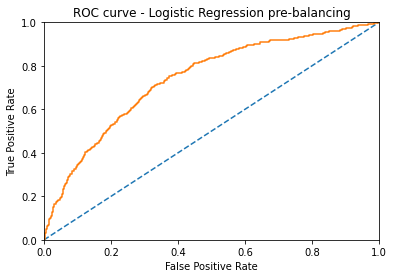

AUC-ROC score:  0.7386410142248726


In [18]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Logistic Regression pre-balancing')
plt.show()

auc_roc = roc_auc_score(target_test,probabilities_one_test)
print('AUC-ROC score: ',auc_roc)

## Class Balance Analysis <a id="claba"></a>

False    0.7885
True     0.2115
Name: Exited, dtype: float64


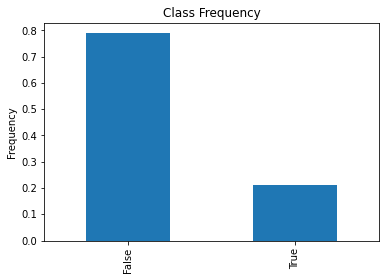

In [19]:
class_frequency = target_test.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Class Frequency')
plt.ylabel('Frequency')
plt.show()

Positive answers make 21% of the data. So no easy "guess all 1" method for the model. It has to get results by really predicting them well.

## Initial Training Summation <a id="intsum"></a>

- Tree approach gives much better initial F1 score to work with, and a better AUC-ROC score.
- Class balance analysis suggests downsampling might be useful.
- In both metrics, RandomForest has the better score - 92% advantage in F1 score, and 14% advantage in AUC-ROC score.

# Fixing Class Imbalance <a id="fxclimb"></a>

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

## Tree Approach <a id="trapp"></a>

In [21]:
ci,tmp = 0,0
for i in range(2,15):
    features_upsampled, target_upsampled = upsample(
        features_train, target_train, i)

    model = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = 25)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > tmp:
        tmp,ci = f1_score(target_valid, predicted_valid),i
print(f'Best repeat - {ci}. F1 score - {tmp}')

Best repeat - 4. F1 score - 0.5997425997425997


In [22]:
ci,tmp = 0,0
for i in range(450, 651, 4):
    features_downsampled, target_downsampled = downsample(
        features_train, target_train, i / 1000
    )

    model = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = 25)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid, predicted_valid),i
        ci = i

print(f'Best fraction - {ci / 1000}. F1 score - {tmp}')   

Best fraction - 0.61. F1 score - 0.6226175349428208


In [23]:
# checking up and down sampling together

features_sampled, target_sampled = upsample(
        features_train, target_train, 4
    )

features_sampled, target_sampled = downsample(
        features_sampled, target_sampled, 0.61
    )


model = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = 25)
model.fit(features_sampled, target_sampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.6013513513513512


Score is lower compared to result obtained using downsampling only. Therefore downsampling will be the sampling method chosen, with `frac` set to 0.61.

In [24]:
features_sampled, target_sampled = downsample(
        features_train, target_train, 0.61)

model = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = 25)
model.fit(features_sampled,target_sampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

ci,tmp = 0,0
for threshold in np.arange(0.3, 0.7, 0.05):
    predicted_valid = probabilities_one_valid > threshold 
    f1 = f1_score(target_valid,predicted_valid)
    if f1 > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), threshold
print(f'Best threshold - {ci:.2f}. F1 score - {tmp}')   

Best threshold - 0.50. F1 score - 0.6226175349428208


Threshold adjustment doesn't further improve F1 score, as 0.5 is threshold's default value

In [25]:
predicted_test = model.predict(features_test)
print('Test set F1 score -',f1_score(target_test,predicted_test))

Test set F1 score - 0.6025641025641025


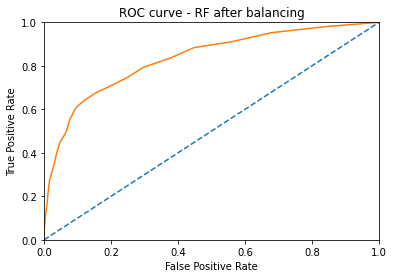

AUC-ROC score:  0.8329832956311998


In [26]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - RF after balancing')
plt.show()

auc_roc = roc_auc_score(target_test,probabilities_one_test)
print('AUC-ROC score: ',auc_roc)

Interestingly, downsampling raised the F1 score from 0.52 to 0.6, but lowered AUC-ROC score from 0.841 to 0.833

## Logistic Regression Approach <a id="lograpp"></a>

In [27]:
tmp, ci = 0,0
for i in range(2,15):
    features_upsampled, target_upsampled = upsample(
        features_train, target_train, i
    )

    model = LogisticRegression(solver='liblinear',random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), i
print(f'Ideal repeat - {ci}. F1 score - {tmp}')   

Ideal repeat - 3. F1 score - 0.5


In [28]:
for i in range(20, 80, 5):
    features_downsampled, target_downsampled = downsample(
        features_train, target_train, i / 100
    )

    model = LogisticRegression(solver='liblinear',random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), i
print(f'Ideal fraction - {ci/100}. F1 score - {tmp}')   

Ideal fraction - 0.4. F1 score - 0.504875406283857


In [29]:
features_sampled, target_sampled = upsample(
        features_train, target_train, 3
    )

features_sampled, target_sampled = downsample(
        features_sampled, target_sampled, 0.4
    )


model = LogisticRegression(solver='liblinear',random_state=12345)
model.fit(features_sampled, target_sampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.4482972136222911


Score is low compared with scores obtained using up/down-sampling seperately. Down sampling had the better result, 0.504 over 0.5, so among the two it'll be the sampling method chosen, with `frac` set to 0.4. Changing the order above between downsampling and upsampling made a negligble difference in F1 score.

In [30]:
features_sampled, target_sampled = downsample(
        features_train, target_train, 0.4)

model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_sampled,target_sampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

tmp, ci = 0,0
for threshold in np.arange(0, 0.8, 0.1):
    predicted_valid = probabilities_one_valid > threshold 
    f1 = f1_score(target_valid,predicted_valid)
    if f1_score(target_valid, predicted_valid) > tmp:
        tmp, ci = f1_score(target_valid,predicted_valid), threshold
print(f'Ideal threshold - {ci}. F1 score - {tmp}')

Ideal threshold - 0.5. F1 score - 0.504875406283857


Again, threshold adjusting didn't improve F1 score

In [31]:
predicted_test = model.predict(features_test)
print('Test set F1 score -',f1_score(target_test,predicted_test))

Test set F1 score - 0.4473975636766334


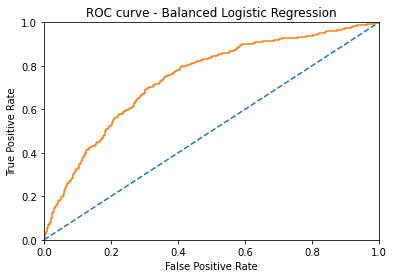

AUC-ROC score:  0.7422328357850965


In [32]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Balanced Logistic Regression')
plt.show()

auc_roc = roc_auc_score(target_test,probabilities_one_test)
print('AUC-ROC score: ',auc_roc)

## Imbalance Fix Summation <a id="imbfsu"></a>

Tree approach F1 and AUC-ROC scores changed by 14% and -1% respectively, and Logistic Regression F1 and AUC-ROC scores improved by 63% and 0.5% respectively, all solely by downsampling. Overall, Tree approach leads to a 35% better F1 score, and to a 12% better AUC-ROC score.

No explanation for the descent in Random-Forest's AUC-ROC score. It might be related to a relatively drastic downsampling (61%) and chance - maybe all samples taken out were FP (or TN) so it made a noted change in the metric.

# Precision-Recall Curves <a id="fintest"></a>

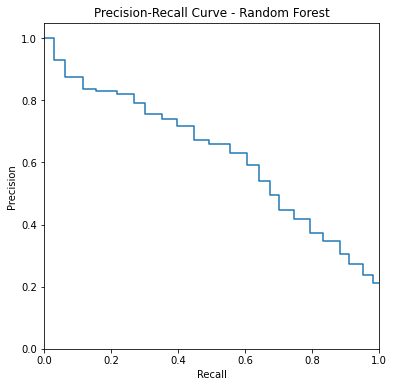

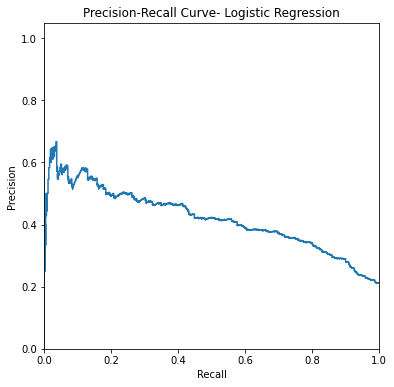

In [33]:
features_sampled, target_sampled = downsample(
        features_train, target_train, 0.61)

rf = RandomForestClassifier(random_state=12345, n_estimators = 23, max_depth = 25)
rf.fit(features_sampled,target_sampled)

probabilities_test = rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

precision, recall, thresholds = precision_recall_curve(
    target_test, probabilities_one_test
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - Random Forest')
plt.show()

features_sampled, target_sampled = downsample(
        features_train, target_train, 0.4)

lgr = LogisticRegression(solver='liblinear', random_state=12345)
lgr.fit(features_sampled,target_sampled)

probabilities_test = lgr.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

precision, recall, thresholds = precision_recall_curve(
    target_test, probabilities_one_test
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve- Logistic Regression')
plt.show()

Logistic Regression precision never pass 0.7, while Random Forest precision starts high and gradually drop as racall approaches 1.

# Conclusion <a id="conc"></a>

- A decent model for predicting customer churn was created, with a F1 score of 0.60 and AUC-ROC of 0.83.
- Tree-based algorithm turned out to be the better choice for this dataset, over logistic regression.
- OHE turned out to be the better method over Label Encoding for relatively small datasets, or at least to this dataset.
- Random Forest's AUC-ROC score dropped by 1% after balancing - still a mystery.